In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  


In [5]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from torch.utils.data import TensorDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random

In [7]:
def seed_all(n=1337):
  np.random.seed(n)
  torch.manual_seed(n)
  random.seed(n)

seed_all(1211)

In [8]:
class Trainer:

    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: None,
                 # lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 path2write: str = None,
                 save_best=False,
                 save_final=True,
                 save_interval=10,
                 checkpoint_start_epoch=50
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        # self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        #             if self.notebook:
        #                 print('Notebook')
        #                 from tqdm.notebook import tqdm, trange
        #             else:
        #                 from tqdm import tqdm, trange
        self.path2write = path2write
        LOG_DIR = os.path.join(path2write, 'Log')  # path2write + 'Log/'
        self.writer_train = SummaryWriter(os.path.join(LOG_DIR, "train"))
        self.writer_val = SummaryWriter(os.path.join(LOG_DIR, "val"))
        self.check_point_path = os.path.join(path2write, 'check_points')
        if not os.path.exists(self.check_point_path):
            os.makedirs(self.check_point_path)
        self.save_best = save_best
        self.save_final = save_final
        self.save_interval = save_interval
        self.checkpoint_start_epoch = checkpoint_start_epoch
        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        self.training_accuracy = []
        self.validation_accuracy = []

    def run_trainer(self):
        self.model.to(self.device)
        #         print(next(self.model.parameters()).device)
        if self.notebook:
            print('Notebook')
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange
        #         print(self.epochs)
        progressbar = trange(self.epochs, desc='Progress', disable=True)  # don't show progressbar
        loss_max = None
        for epoch in progressbar:
            print(f'Epoch - {epoch}')

            # Training Block
            train_loss, train_accuracy = self._train()
            self.writer_train.add_scalar("Train Loss", train_loss, epoch)
            self.writer_train.add_scalar("Train Accuracy", train_accuracy, epoch)


            # Val Block
            val_loss, val_accuracy = self._validate()
            self.writer_val.add_scalar("Val Loss", val_loss, epoch)
            self.writer_val.add_scalar("Val Accuracy", val_accuracy, epoch)

            # lr
            self.writer_train.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            print('Epoch - {} Train Loss - {:.6f} Val Loss - {:.6f} Train Accuracy - {:.6f} Val Accuracy - {:.6f}'.format(epoch, train_loss, val_loss, train_accuracy, val_accuracy))
            if self.save_final:
                if epoch == self.epochs-1:
                    model_name = 'epoch-{}-loss{:.6f}'.format(epoch, val_loss)
                    torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))
            # if epoch == 0:
            #     loss_max = val_loss
            #     print(loss_max)
            #     pass
            # if self.save_best and epoch >= self.checkpoint_start_epoch:
            #     if val_loss < loss_max:  # loss decreased
            #         print('Saving Checkpoint at val loss dropped from {:.6f} -> {:.6f}'.format(loss_max, val_loss))
            #         model_name = 'epoch-{}-loss{:.6f}'.format(epoch, val_loss)
            #         # torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))
            # elif epoch % self.save_interval == 0:
            #     print('Saving Checkpoint Val loss - {:.6f}'.format(val_loss))
            #     model_name = 'epoch-{}-loss{:.6f}'.format(epoch, val_loss)
            #     torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))
            loss_max = val_loss

        return self.training_loss, self.validation_loss, self.model, self.training_accuracy, self.validation_accuracy

    def _train(self):

        self.model.train()
        train_losses = []
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          disable=False)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            target = target.type(torch.LongTensor).to(self.device)
            output = self.model(input)
            # target = target.unsqueeze(-1)
            # print('Target Shape - ', target.shape)
            # print('Output Shape - ', output.shape)
            loss = self.criterion(output, target)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
            pred = output.argmax(dim=1, keepdim=True) # max of prob
            pred = pred.flatten()
            # correct += pred.eq(target.view_as(pred)).sum().item() 
            batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor))
            # batch_acc += (sum(pred.eq(target.view_as(pred)).type(torch.FloatTensor))/len(pred.eq(target.view_as(pred)).type(torch.FloatTensor)))
        accuracy = batch_acc/len(self.training_DataLoader)
        self.training_loss.append(np.mean(train_losses))  # Mean batch loss
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])
        self.training_accuracy.append(accuracy)

        batch_iter.close()  # clean up the bar
        return np.mean(train_losses), accuracy

    def _validate(self):

        self.model.eval()
        valid_losses = []
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'validation', total=len(self.validation_DataLoader), disable=False)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.to(self.device)
            with torch.no_grad():
                output = self.model(input)
                # target = target.unsqueeze(-1)
                target = target.type(torch.LongTensor).to(self.device)
                loss = self.criterion(output, target)
                valid_losses.append(loss.item())
                pred = output.argmax(dim=1, keepdim=True)
                # correct += pred.eq(target.view_as(pred)).sum().item()
                batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor)).item()

        accuracy = batch_acc/len(self.validation_DataLoader)
        self.validation_loss.append(np.mean(valid_losses))
        self.validation_accuracy.append(accuracy)
        batch_iter.close()
        return np.mean(valid_losses), accuracy

In [9]:
class CNN0(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) #op dim stays same #  (W - F + 2*P)/S + 1
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 

    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # half of input
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dense1 = nn.Linear(64*7*7, 128) #(28/2/2) -> 7
    self.dense2 = nn.Linear(128, 10)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = x.view(x.shape[0], -1)
    x = self.dense1(x)
    x = self.dense2(x)
    output = F.log_softmax(x, dim=1)
    return output

class CNN1(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # half of input
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dense1 = nn.Linear(128*7*7, 128)
    self.dense2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = x.view(x.shape[0], -1) #flatten the vector
    x = self.dense1(x)
    x = self.dense2(x)
    output = F.log_softmax(x, dim=1)
    return output

class CNN2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dense1 = nn.Linear(32*14*14, 128)
    self.dense2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = x.view(x.shape[0], -1)
    x = self.dense1(x)
    x = self.dense2(x)
    out = F.log_softmax(x)
    return out

class DNN0(nn.Module): #for mnist
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Conv2d(28*28, 64)
    self.layer2 = nn.Conv2d(64, 32)
    self.layer3 = nn.Conv2d(32, 16)
    self.layer4 = nn.Conv2d(16, 10)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    out = F.log_softmax(x)

    return out

class DNN1(nn.Module): #for mnist
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Conv2d(28*28, 32)
    self.layer2 = nn.Conv2d(32, 16)
    self.layer3 = nn.Conv2d(16, 10)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    out = F.log_softmax(x)

    return out

class DNN2(nn.Module): #for mnist
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Conv2d(28*28, 64)
    self.layer2 = nn.Conv2d(64, 32)
    self.layer3 = nn.Conv2d(32, 16)
    self.layer4 = nn.Conv2d(16, 10)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    out = F.log_softmax(x)

    return out




In [16]:
#dataset prepration
bath_size = 1024

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST(root='Home work', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(root='Home work', train=False, transform=transform)

training_DataLoader = DataLoader(dataset1, batch_size=bath_size, shuffle=True)
validation_DataLoader= DataLoader(dataset2, batch_size=bath_size, shuffle=True)

In [17]:
gpu_id = 0
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
epochs =  50
notebook = True
checkpoint_start_epoch = 5 #Not using
path2write = "drive/MyDrive/DL_homework/HW1_1/CNN/"

In [20]:
model0 = CNN0()
optimizer = torch.optim.Adam(model0.parameters(), lr = lr)
trainer = Trainer(model=model0,
                      device=gpu_id,
                      criterion=loss_fn,
                      optimizer=optimizer,
                      training_DataLoader=training_DataLoader,
                      validation_DataLoader=validation_DataLoader,
                      # lr_scheduler=lr_scheduler,
                      epochs=epochs,
                      epoch=0,
                      notebook=True,
                      path2write= path2write,
                      checkpoint_start_epoch=checkpoint_start_epoch )
training_loss0, validation_loss0, model0, training_accuracy0, validation_accuracy0 = trainer.run_trainer()

Notebook
Epoch - 0


validation: 100%|██████████| 10/10 [00:00<00:00, 15.42it/s]


Epoch - 0 Train Loss - 1.939678 Val Loss - 1.332731 Train Accuracy - 0.617537 Val Accuracy - 0.804432
Epoch - 1


validation: 100%|██████████| 10/10 [00:00<00:00, 15.39it/s]


Epoch - 1 Train Loss - 0.849737 Val Loss - 0.528177 Train Accuracy - 0.825031 Val Accuracy - 0.872889
Epoch - 2


validation: 100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


Epoch - 2 Train Loss - 0.443638 Val Loss - 0.358662 Train Accuracy - 0.882170 Val Accuracy - 0.904165
Epoch - 3


validation: 100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


Epoch - 3 Train Loss - 0.334068 Val Loss - 0.290248 Train Accuracy - 0.906625 Val Accuracy - 0.919346
Epoch - 4


validation: 100%|██████████| 10/10 [00:00<00:00, 15.42it/s]


Epoch - 4 Train Loss - 0.279715 Val Loss - 0.252381 Train Accuracy - 0.919909 Val Accuracy - 0.928833
Epoch - 5


validation: 100%|██████████| 10/10 [00:00<00:00, 15.40it/s]


Epoch - 5 Train Loss - 0.242917 Val Loss - 0.216040 Train Accuracy - 0.930255 Val Accuracy - 0.938401
Epoch - 6


validation: 100%|██████████| 10/10 [00:00<00:00, 15.41it/s]


Epoch - 6 Train Loss - 0.213936 Val Loss - 0.190095 Train Accuracy - 0.937397 Val Accuracy - 0.944621
Epoch - 7


validation: 100%|██████████| 10/10 [00:00<00:00, 15.29it/s]


Epoch - 7 Train Loss - 0.189871 Val Loss - 0.169672 Train Accuracy - 0.944580 Val Accuracy - 0.951891
Epoch - 8


validation: 100%|██████████| 10/10 [00:00<00:00, 15.20it/s]


Epoch - 8 Train Loss - 0.168689 Val Loss - 0.148816 Train Accuracy - 0.950552 Val Accuracy - 0.956758
Epoch - 9


validation: 100%|██████████| 10/10 [00:00<00:00, 15.32it/s]


Epoch - 9 Train Loss - 0.151015 Val Loss - 0.132861 Train Accuracy - 0.956010 Val Accuracy - 0.961402
Epoch - 10


validation: 100%|██████████| 10/10 [00:00<00:00, 15.50it/s]


Epoch - 10 Train Loss - 0.136232 Val Loss - 0.119867 Train Accuracy - 0.960469 Val Accuracy - 0.965240
Epoch - 11


validation: 100%|██████████| 10/10 [00:00<00:00, 15.46it/s]


Epoch - 11 Train Loss - 0.123662 Val Loss - 0.107802 Train Accuracy - 0.964313 Val Accuracy - 0.967642
Epoch - 12


validation: 100%|██████████| 10/10 [00:00<00:00, 15.35it/s]


Epoch - 12 Train Loss - 0.112496 Val Loss - 0.097870 Train Accuracy - 0.967763 Val Accuracy - 0.971773
Epoch - 13


validation: 100%|██████████| 10/10 [00:00<00:00, 15.40it/s]


Epoch - 13 Train Loss - 0.104354 Val Loss - 0.090145 Train Accuracy - 0.970026 Val Accuracy - 0.973515
Epoch - 14


validation: 100%|██████████| 10/10 [00:00<00:00, 15.27it/s]


Epoch - 14 Train Loss - 0.096718 Val Loss - 0.085305 Train Accuracy - 0.972111 Val Accuracy - 0.974289
Epoch - 15


validation: 100%|██████████| 10/10 [00:00<00:00, 15.50it/s]


Epoch - 15 Train Loss - 0.090600 Val Loss - 0.080890 Train Accuracy - 0.973926 Val Accuracy - 0.976258
Epoch - 16


validation: 100%|██████████| 10/10 [00:00<00:00, 15.47it/s]


Epoch - 16 Train Loss - 0.084969 Val Loss - 0.074260 Train Accuracy - 0.975605 Val Accuracy - 0.977519
Epoch - 17


validation: 100%|██████████| 10/10 [00:00<00:00, 15.38it/s]


Epoch - 17 Train Loss - 0.080963 Val Loss - 0.072092 Train Accuracy - 0.976718 Val Accuracy - 0.978263
Epoch - 18


validation: 100%|██████████| 10/10 [00:00<00:00, 15.31it/s]


Epoch - 18 Train Loss - 0.076380 Val Loss - 0.067401 Train Accuracy - 0.978551 Val Accuracy - 0.979060
Epoch - 19


validation: 100%|██████████| 10/10 [00:00<00:00, 15.41it/s]


Epoch - 19 Train Loss - 0.073664 Val Loss - 0.066333 Train Accuracy - 0.978915 Val Accuracy - 0.979412
Epoch - 20


validation: 100%|██████████| 10/10 [00:00<00:00, 15.36it/s]


Epoch - 20 Train Loss - 0.070977 Val Loss - 0.062244 Train Accuracy - 0.980024 Val Accuracy - 0.980546
Epoch - 21


validation: 100%|██████████| 10/10 [00:00<00:00, 15.44it/s]


Epoch - 21 Train Loss - 0.067982 Val Loss - 0.060985 Train Accuracy - 0.980648 Val Accuracy - 0.980953
Epoch - 22


validation: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s]


Epoch - 22 Train Loss - 0.065130 Val Loss - 0.058167 Train Accuracy - 0.981630 Val Accuracy - 0.980899
Epoch - 23


validation: 100%|██████████| 10/10 [00:00<00:00, 15.27it/s]


Epoch - 23 Train Loss - 0.063145 Val Loss - 0.058724 Train Accuracy - 0.981950 Val Accuracy - 0.981320
Epoch - 24


validation: 100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


Epoch - 24 Train Loss - 0.061289 Val Loss - 0.056767 Train Accuracy - 0.982513 Val Accuracy - 0.982326
Epoch - 25


validation: 100%|██████████| 10/10 [00:00<00:00, 15.52it/s]


Epoch - 25 Train Loss - 0.058991 Val Loss - 0.053541 Train Accuracy - 0.983032 Val Accuracy - 0.982649
Epoch - 26


validation: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s]


Epoch - 26 Train Loss - 0.057618 Val Loss - 0.052546 Train Accuracy - 0.983483 Val Accuracy - 0.982237
Epoch - 27


validation: 100%|██████████| 10/10 [00:00<00:00, 15.37it/s]


Epoch - 27 Train Loss - 0.055488 Val Loss - 0.054143 Train Accuracy - 0.983921 Val Accuracy - 0.981756
Epoch - 28


validation: 100%|██████████| 10/10 [00:00<00:00, 15.54it/s]


Epoch - 28 Train Loss - 0.054031 Val Loss - 0.049988 Train Accuracy - 0.984619 Val Accuracy - 0.983333
Epoch - 29


validation: 100%|██████████| 10/10 [00:00<00:00, 15.25it/s]


Epoch - 29 Train Loss - 0.052514 Val Loss - 0.049767 Train Accuracy - 0.984885 Val Accuracy - 0.983235
Epoch - 30


validation: 100%|██████████| 10/10 [00:00<00:00, 15.42it/s]


Epoch - 30 Train Loss - 0.052112 Val Loss - 0.047997 Train Accuracy - 0.984813 Val Accuracy - 0.983875
Epoch - 31


validation: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s]


Epoch - 31 Train Loss - 0.050030 Val Loss - 0.047115 Train Accuracy - 0.985642 Val Accuracy - 0.984662
Epoch - 32


validation: 100%|██████████| 10/10 [00:00<00:00, 15.45it/s]


Epoch - 32 Train Loss - 0.049039 Val Loss - 0.047259 Train Accuracy - 0.985829 Val Accuracy - 0.984542
Epoch - 33


validation: 100%|██████████| 10/10 [00:00<00:00, 15.52it/s]


Epoch - 33 Train Loss - 0.047819 Val Loss - 0.045502 Train Accuracy - 0.986373 Val Accuracy - 0.985174
Epoch - 34


validation: 100%|██████████| 10/10 [00:00<00:00, 15.45it/s]


Epoch - 34 Train Loss - 0.046761 Val Loss - 0.045055 Train Accuracy - 0.986243 Val Accuracy - 0.985120
Epoch - 35


validation: 100%|██████████| 10/10 [00:00<00:00, 11.33it/s]


Epoch - 35 Train Loss - 0.045556 Val Loss - 0.044163 Train Accuracy - 0.987088 Val Accuracy - 0.984776
Epoch - 36


validation: 100%|██████████| 10/10 [00:00<00:00, 15.54it/s]


Epoch - 36 Train Loss - 0.044737 Val Loss - 0.044802 Train Accuracy - 0.987103 Val Accuracy - 0.985924
Epoch - 37


validation: 100%|██████████| 10/10 [00:00<00:00, 15.51it/s]


Epoch - 37 Train Loss - 0.043508 Val Loss - 0.043317 Train Accuracy - 0.987280 Val Accuracy - 0.985182
Epoch - 38


validation: 100%|██████████| 10/10 [00:00<00:00, 15.49it/s]


Epoch - 38 Train Loss - 0.043305 Val Loss - 0.043521 Train Accuracy - 0.987517 Val Accuracy - 0.986308
Epoch - 39


validation: 100%|██████████| 10/10 [00:00<00:00, 15.58it/s]


Epoch - 39 Train Loss - 0.042087 Val Loss - 0.042006 Train Accuracy - 0.987745 Val Accuracy - 0.985481
Epoch - 40


validation: 100%|██████████| 10/10 [00:00<00:00, 15.56it/s]


Epoch - 40 Train Loss - 0.040858 Val Loss - 0.040996 Train Accuracy - 0.988158 Val Accuracy - 0.986585
Epoch - 41


validation: 100%|██████████| 10/10 [00:00<00:00, 15.54it/s]


Epoch - 41 Train Loss - 0.039622 Val Loss - 0.040786 Train Accuracy - 0.988506 Val Accuracy - 0.986466
Epoch - 42


validation: 100%|██████████| 10/10 [00:00<00:00, 15.32it/s]


Epoch - 42 Train Loss - 0.040006 Val Loss - 0.040268 Train Accuracy - 0.988472 Val Accuracy - 0.986938
Epoch - 43


validation: 100%|██████████| 10/10 [00:00<00:00, 15.37it/s]


Epoch - 43 Train Loss - 0.039508 Val Loss - 0.041690 Train Accuracy - 0.988625 Val Accuracy - 0.986645
Epoch - 44


validation: 100%|██████████| 10/10 [00:00<00:00, 11.34it/s]


Epoch - 44 Train Loss - 0.038872 Val Loss - 0.041532 Train Accuracy - 0.988793 Val Accuracy - 0.986308
Epoch - 45


validation: 100%|██████████| 10/10 [00:00<00:00, 15.47it/s]


Epoch - 45 Train Loss - 0.037454 Val Loss - 0.039742 Train Accuracy - 0.989222 Val Accuracy - 0.986224
Epoch - 46


validation: 100%|██████████| 10/10 [00:00<00:00, 15.44it/s]


Epoch - 46 Train Loss - 0.037223 Val Loss - 0.038598 Train Accuracy - 0.989195 Val Accuracy - 0.985676
Epoch - 47


validation: 100%|██████████| 10/10 [00:00<00:00, 15.38it/s]


Epoch - 47 Train Loss - 0.036072 Val Loss - 0.040206 Train Accuracy - 0.989377 Val Accuracy - 0.985001
Epoch - 48


validation: 100%|██████████| 10/10 [00:00<00:00, 15.58it/s]


Epoch - 48 Train Loss - 0.035893 Val Loss - 0.038745 Train Accuracy - 0.989702 Val Accuracy - 0.986653
Epoch - 49


validation: 100%|██████████| 10/10 [00:00<00:00, 15.30it/s]

Epoch - 49 Train Loss - 0.034820 Val Loss - 0.037478 Train Accuracy - 0.989962 Val Accuracy - 0.987163


In [22]:
model1 = CNN1()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
trainer = Trainer(model=model1,
                      device=gpu_id,
                      criterion=loss_fn,
                      optimizer=optimizer,
                      training_DataLoader=training_DataLoader,
                      validation_DataLoader=validation_DataLoader,
                      # lr_scheduler=lr_scheduler,
                      epochs=epochs,
                      epoch=0,
                      notebook=True,
                      path2write= path2write,
                      checkpoint_start_epoch=checkpoint_start_epoch )
training_loss1, validation_loss1, model1, training_accuracy1, validation_accuracy1 = trainer.run_trainer()

Notebook
Epoch - 0


validation: 100%|██████████| 10/10 [00:00<00:00, 15.49it/s]


Epoch - 0 Train Loss - 1.693749 Val Loss - 0.746753 Train Accuracy - 0.624003 Val Accuracy - 0.808347
Epoch - 1


validation: 100%|██████████| 10/10 [00:00<00:00, 15.56it/s]


Epoch - 1 Train Loss - 0.514259 Val Loss - 0.377082 Train Accuracy - 0.851712 Val Accuracy - 0.889286
Epoch - 2


validation: 100%|██████████| 10/10 [00:00<00:00, 15.61it/s]


Epoch - 2 Train Loss - 0.349378 Val Loss - 0.296155 Train Accuracy - 0.895403 Val Accuracy - 0.911802
Epoch - 3


validation: 100%|██████████| 10/10 [00:00<00:00, 15.50it/s]


Epoch - 3 Train Loss - 0.282933 Val Loss - 0.242541 Train Accuracy - 0.916947 Val Accuracy - 0.927419
Epoch - 4


validation: 100%|██████████| 10/10 [00:00<00:00, 15.39it/s]


Epoch - 4 Train Loss - 0.235439 Val Loss - 0.199134 Train Accuracy - 0.930014 Val Accuracy - 0.942186
Epoch - 5


validation: 100%|██████████| 10/10 [00:00<00:00, 15.39it/s]


Epoch - 5 Train Loss - 0.193138 Val Loss - 0.162194 Train Accuracy - 0.942781 Val Accuracy - 0.952770
Epoch - 6


validation: 100%|██████████| 10/10 [00:00<00:00, 15.54it/s]


Epoch - 6 Train Loss - 0.159320 Val Loss - 0.131764 Train Accuracy - 0.952675 Val Accuracy - 0.962159
Epoch - 7


validation: 100%|██████████| 10/10 [00:00<00:00, 12.03it/s]


Epoch - 7 Train Loss - 0.131756 Val Loss - 0.111479 Train Accuracy - 0.960847 Val Accuracy - 0.966223
Epoch - 8


validation: 100%|██████████| 10/10 [00:00<00:00, 15.63it/s]


Epoch - 8 Train Loss - 0.114463 Val Loss - 0.096080 Train Accuracy - 0.966279 Val Accuracy - 0.971429
Epoch - 9


validation: 100%|██████████| 10/10 [00:00<00:00, 15.55it/s]


Epoch - 9 Train Loss - 0.101194 Val Loss - 0.085546 Train Accuracy - 0.970026 Val Accuracy - 0.974334
Epoch - 10


validation: 100%|██████████| 10/10 [00:00<00:00, 15.66it/s]


Epoch - 10 Train Loss - 0.089763 Val Loss - 0.075794 Train Accuracy - 0.973363 Val Accuracy - 0.977541
Epoch - 11


validation: 100%|██████████| 10/10 [00:00<00:00, 15.70it/s]


Epoch - 11 Train Loss - 0.082543 Val Loss - 0.068025 Train Accuracy - 0.975558 Val Accuracy - 0.979630
Epoch - 12


validation: 100%|██████████| 10/10 [00:00<00:00, 15.62it/s]


Epoch - 12 Train Loss - 0.076524 Val Loss - 0.063285 Train Accuracy - 0.977330 Val Accuracy - 0.981176
Epoch - 13


validation: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s]


Epoch - 13 Train Loss - 0.071900 Val Loss - 0.062356 Train Accuracy - 0.978637 Val Accuracy - 0.980277
Epoch - 14


validation: 100%|██████████| 10/10 [00:00<00:00, 15.41it/s]


Epoch - 14 Train Loss - 0.066598 Val Loss - 0.056760 Train Accuracy - 0.980961 Val Accuracy - 0.982492
Epoch - 15


validation: 100%|██████████| 10/10 [00:00<00:00, 15.63it/s]


Epoch - 15 Train Loss - 0.062828 Val Loss - 0.053007 Train Accuracy - 0.981475 Val Accuracy - 0.982320
Epoch - 16


validation: 100%|██████████| 10/10 [00:00<00:00, 15.64it/s]


Epoch - 16 Train Loss - 0.059554 Val Loss - 0.055296 Train Accuracy - 0.982541 Val Accuracy - 0.982101
Epoch - 17


validation: 100%|██████████| 10/10 [00:00<00:00, 15.68it/s]


Epoch - 17 Train Loss - 0.057581 Val Loss - 0.050018 Train Accuracy - 0.982964 Val Accuracy - 0.983257
Epoch - 18


validation: 100%|██████████| 10/10 [00:00<00:00, 15.64it/s]


Epoch - 18 Train Loss - 0.054032 Val Loss - 0.045676 Train Accuracy - 0.984212 Val Accuracy - 0.984798
Epoch - 19


validation: 100%|██████████| 10/10 [00:00<00:00, 15.54it/s]


Epoch - 19 Train Loss - 0.051372 Val Loss - 0.045991 Train Accuracy - 0.984907 Val Accuracy - 0.984301
Epoch - 20


validation: 100%|██████████| 10/10 [00:00<00:00, 15.68it/s]


Epoch - 20 Train Loss - 0.050077 Val Loss - 0.043994 Train Accuracy - 0.985239 Val Accuracy - 0.985308
Epoch - 21


validation: 100%|██████████| 10/10 [00:00<00:00, 15.60it/s]


Epoch - 21 Train Loss - 0.048663 Val Loss - 0.043387 Train Accuracy - 0.985531 Val Accuracy - 0.984955
Epoch - 22


validation: 100%|██████████| 10/10 [00:00<00:00, 15.64it/s]


Epoch - 22 Train Loss - 0.047281 Val Loss - 0.042937 Train Accuracy - 0.986293 Val Accuracy - 0.985001
Epoch - 23


validation: 100%|██████████| 10/10 [00:00<00:00, 15.70it/s]


Epoch - 23 Train Loss - 0.045026 Val Loss - 0.041464 Train Accuracy - 0.986972 Val Accuracy - 0.985150
Epoch - 24


validation: 100%|██████████| 10/10 [00:00<00:00, 15.74it/s]


Epoch - 24 Train Loss - 0.043914 Val Loss - 0.040789 Train Accuracy - 0.986761 Val Accuracy - 0.985346
Epoch - 25


validation: 100%|██████████| 10/10 [00:00<00:00, 15.78it/s]


Epoch - 25 Train Loss - 0.042043 Val Loss - 0.039446 Train Accuracy - 0.987655 Val Accuracy - 0.986488
Epoch - 26


validation: 100%|██████████| 10/10 [00:00<00:00, 15.60it/s]


Epoch - 26 Train Loss - 0.040807 Val Loss - 0.038592 Train Accuracy - 0.988175 Val Accuracy - 0.985924
Epoch - 27


validation: 100%|██████████| 10/10 [00:00<00:00, 15.61it/s]


Epoch - 27 Train Loss - 0.039600 Val Loss - 0.035241 Train Accuracy - 0.988295 Val Accuracy - 0.987095
Epoch - 28


validation: 100%|██████████| 10/10 [00:00<00:00, 15.71it/s]


Epoch - 28 Train Loss - 0.038603 Val Loss - 0.036540 Train Accuracy - 0.988892 Val Accuracy - 0.986976
Epoch - 29


validation: 100%|██████████| 10/10 [00:00<00:00, 15.73it/s]


Epoch - 29 Train Loss - 0.037540 Val Loss - 0.034557 Train Accuracy - 0.988627 Val Accuracy - 0.988215
Epoch - 30


validation: 100%|██████████| 10/10 [00:00<00:00, 15.47it/s]


Epoch - 30 Train Loss - 0.036498 Val Loss - 0.034819 Train Accuracy - 0.989036 Val Accuracy - 0.986802
Epoch - 31


validation: 100%|██████████| 10/10 [00:00<00:00, 15.38it/s]


Epoch - 31 Train Loss - 0.035166 Val Loss - 0.034227 Train Accuracy - 0.989608 Val Accuracy - 0.988118
Epoch - 32


validation: 100%|██████████| 10/10 [00:00<00:00, 15.65it/s]


Epoch - 32 Train Loss - 0.035477 Val Loss - 0.034647 Train Accuracy - 0.989674 Val Accuracy - 0.987952
Epoch - 33


validation: 100%|██████████| 10/10 [00:00<00:00, 15.66it/s]


Epoch - 33 Train Loss - 0.033732 Val Loss - 0.031589 Train Accuracy - 0.989974 Val Accuracy - 0.988734
Epoch - 34


validation: 100%|██████████| 10/10 [00:00<00:00, 15.59it/s]


Epoch - 34 Train Loss - 0.032955 Val Loss - 0.032869 Train Accuracy - 0.990354 Val Accuracy - 0.988215
Epoch - 35


validation: 100%|██████████| 10/10 [00:00<00:00, 15.64it/s]


Epoch - 35 Train Loss - 0.031961 Val Loss - 0.034783 Train Accuracy - 0.990408 Val Accuracy - 0.987749
Epoch - 36


validation: 100%|██████████| 10/10 [00:00<00:00, 15.42it/s]


Epoch - 36 Train Loss - 0.031361 Val Loss - 0.031297 Train Accuracy - 0.990889 Val Accuracy - 0.988883
Epoch - 37


validation: 100%|██████████| 10/10 [00:00<00:00, 15.51it/s]


Epoch - 37 Train Loss - 0.030437 Val Loss - 0.032515 Train Accuracy - 0.991044 Val Accuracy - 0.988471
Epoch - 38


validation: 100%|██████████| 10/10 [00:00<00:00, 15.55it/s]


Epoch - 38 Train Loss - 0.029823 Val Loss - 0.030364 Train Accuracy - 0.990834 Val Accuracy - 0.989792
Epoch - 39


validation: 100%|██████████| 10/10 [00:00<00:00, 15.70it/s]


Epoch - 39 Train Loss - 0.028258 Val Loss - 0.029654 Train Accuracy - 0.991591 Val Accuracy - 0.989049
Epoch - 40


validation: 100%|██████████| 10/10 [00:00<00:00, 15.50it/s]


Epoch - 40 Train Loss - 0.028393 Val Loss - 0.031500 Train Accuracy - 0.991469 Val Accuracy - 0.988598
Epoch - 41


validation: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s]


Epoch - 41 Train Loss - 0.027216 Val Loss - 0.032289 Train Accuracy - 0.992148 Val Accuracy - 0.988682
Epoch - 42


validation: 100%|██████████| 10/10 [00:00<00:00, 15.58it/s]


Epoch - 42 Train Loss - 0.026870 Val Loss - 0.030125 Train Accuracy - 0.991939 Val Accuracy - 0.988929
Epoch - 43


validation: 100%|██████████| 10/10 [00:00<00:00, 15.68it/s]


Epoch - 43 Train Loss - 0.026194 Val Loss - 0.029447 Train Accuracy - 0.992451 Val Accuracy - 0.989830
Epoch - 44


validation: 100%|██████████| 10/10 [00:00<00:00, 15.69it/s]


Epoch - 44 Train Loss - 0.025350 Val Loss - 0.027688 Train Accuracy - 0.992512 Val Accuracy - 0.990191
Epoch - 45


validation: 100%|██████████| 10/10 [00:00<00:00, 15.58it/s]


Epoch - 45 Train Loss - 0.025026 Val Loss - 0.030221 Train Accuracy - 0.992534 Val Accuracy - 0.990071
Epoch - 46


validation: 100%|██████████| 10/10 [00:00<00:00, 15.57it/s]


Epoch - 46 Train Loss - 0.024329 Val Loss - 0.027842 Train Accuracy - 0.992776 Val Accuracy - 0.989822
Epoch - 47


validation: 100%|██████████| 10/10 [00:00<00:00, 15.56it/s]


Epoch - 47 Train Loss - 0.023452 Val Loss - 0.026703 Train Accuracy - 0.993363 Val Accuracy - 0.990220
Epoch - 48


validation: 100%|██████████| 10/10 [00:00<00:00, 15.55it/s]


Epoch - 48 Train Loss - 0.022744 Val Loss - 0.028920 Train Accuracy - 0.993577 Val Accuracy - 0.990071
Epoch - 49


validation: 100%|██████████| 10/10 [00:00<00:00, 15.56it/s]

Epoch - 49 Train Loss - 0.022357 Val Loss - 0.028420 Train Accuracy - 0.993500 Val Accuracy - 0.990499


In [23]:
model2 = CNN2()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
trainer = Trainer(model=model2,
                      device=gpu_id,
                      criterion=loss_fn,
                      optimizer=optimizer,
                      training_DataLoader=training_DataLoader,
                      validation_DataLoader=validation_DataLoader,
                      # lr_scheduler=lr_scheduler,
                      epochs=epochs,
                      epoch=0,
                      notebook=True,
                      path2write= path2write,
                      checkpoint_start_epoch=checkpoint_start_epoch )
training_loss2, validation_loss2, model2, training_accuracy2, validation_accuracy2 = trainer.run_trainer()

Notebook
Epoch - 0


Training:   0%|          | 0/59 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_652033/3791466477.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 10/10 [00:00<00:00, 15.90it/s]


Epoch - 0 Train Loss - 2.313547 Val Loss - 2.315073 Train Accuracy - 0.094375 Val Accuracy - 0.086858
Epoch - 1


validation: 100%|██████████| 10/10 [00:00<00:00, 15.87it/s]


Epoch - 1 Train Loss - 2.313571 Val Loss - 2.314961 Train Accuracy - 0.094329 Val Accuracy - 0.086649
Epoch - 2


validation: 100%|██████████| 10/10 [00:00<00:00, 15.88it/s]


Epoch - 2 Train Loss - 2.313585 Val Loss - 2.315151 Train Accuracy - 0.094239 Val Accuracy - 0.086649
Epoch - 3


validation: 100%|██████████| 10/10 [00:00<00:00, 15.73it/s]


Epoch - 3 Train Loss - 2.313563 Val Loss - 2.315048 Train Accuracy - 0.094239 Val Accuracy - 0.086739
Epoch - 4


validation: 100%|██████████| 10/10 [00:00<00:00, 15.78it/s]


Epoch - 4 Train Loss - 2.313532 Val Loss - 2.315057 Train Accuracy - 0.094397 Val Accuracy - 0.086440
Epoch - 5


validation: 100%|██████████| 10/10 [00:00<00:00, 15.88it/s]


Epoch - 5 Train Loss - 2.313554 Val Loss - 2.314932 Train Accuracy - 0.094239 Val Accuracy - 0.086769
Epoch - 6


validation: 100%|██████████| 10/10 [00:00<00:00, 15.71it/s]


Epoch - 6 Train Loss - 2.313583 Val Loss - 2.315018 Train Accuracy - 0.094363 Val Accuracy - 0.086888
Epoch - 7


validation: 100%|██████████| 10/10 [00:00<00:00, 15.81it/s]


Epoch - 7 Train Loss - 2.313555 Val Loss - 2.314949 Train Accuracy - 0.094397 Val Accuracy - 0.086858
Epoch - 8


validation: 100%|██████████| 10/10 [00:00<00:00, 15.66it/s]


Epoch - 8 Train Loss - 2.313616 Val Loss - 2.315027 Train Accuracy - 0.094227 Val Accuracy - 0.086470
Epoch - 9


validation: 100%|██████████| 10/10 [00:00<00:00, 15.87it/s]


Epoch - 9 Train Loss - 2.313559 Val Loss - 2.315126 Train Accuracy - 0.094318 Val Accuracy - 0.086529
Epoch - 10


validation: 100%|██████████| 10/10 [00:00<00:00, 15.79it/s]


Epoch - 10 Train Loss - 2.313543 Val Loss - 2.315085 Train Accuracy - 0.094431 Val Accuracy - 0.086589
Epoch - 11


validation: 100%|██████████| 10/10 [00:00<00:00, 15.87it/s]


Epoch - 11 Train Loss - 2.313523 Val Loss - 2.314972 Train Accuracy - 0.094409 Val Accuracy - 0.086709
Epoch - 12


validation: 100%|██████████| 10/10 [00:00<00:00, 15.68it/s]


Epoch - 12 Train Loss - 2.313553 Val Loss - 2.315018 Train Accuracy - 0.094397 Val Accuracy - 0.086619
Epoch - 13


validation: 100%|██████████| 10/10 [00:00<00:00, 15.00it/s]


Epoch - 13 Train Loss - 2.313550 Val Loss - 2.314852 Train Accuracy - 0.094465 Val Accuracy - 0.086828
Epoch - 14


validation: 100%|██████████| 10/10 [00:00<00:00, 15.71it/s]


Epoch - 14 Train Loss - 2.313579 Val Loss - 2.315003 Train Accuracy - 0.094397 Val Accuracy - 0.086918
Epoch - 15


validation: 100%|██████████| 10/10 [00:00<00:00, 14.94it/s]


Epoch - 15 Train Loss - 2.313524 Val Loss - 2.314937 Train Accuracy - 0.094341 Val Accuracy - 0.087008
Epoch - 16


validation: 100%|██████████| 10/10 [00:00<00:00, 15.88it/s]


Epoch - 16 Train Loss - 2.313555 Val Loss - 2.314875 Train Accuracy - 0.094386 Val Accuracy - 0.086858
Epoch - 17


validation: 100%|██████████| 10/10 [00:00<00:00, 15.06it/s]


Epoch - 17 Train Loss - 2.313512 Val Loss - 2.314974 Train Accuracy - 0.094329 Val Accuracy - 0.087038
Epoch - 18


validation: 100%|██████████| 10/10 [00:00<00:00, 15.05it/s]


Epoch - 18 Train Loss - 2.313535 Val Loss - 2.314957 Train Accuracy - 0.094511 Val Accuracy - 0.086739
Epoch - 19


validation: 100%|██████████| 10/10 [00:00<00:00, 15.03it/s]


Epoch - 19 Train Loss - 2.313571 Val Loss - 2.314918 Train Accuracy - 0.094386 Val Accuracy - 0.086739
Epoch - 20


validation: 100%|██████████| 10/10 [00:00<00:00, 15.01it/s]


Epoch - 20 Train Loss - 2.313577 Val Loss - 2.314856 Train Accuracy - 0.094182 Val Accuracy - 0.086948
Epoch - 21


validation: 100%|██████████| 10/10 [00:00<00:00, 15.86it/s]


Epoch - 21 Train Loss - 2.313569 Val Loss - 2.315047 Train Accuracy - 0.094261 Val Accuracy - 0.086559
Epoch - 22


validation: 100%|██████████| 10/10 [00:00<00:00, 15.07it/s]


Epoch - 22 Train Loss - 2.313566 Val Loss - 2.314983 Train Accuracy - 0.094397 Val Accuracy - 0.086798
Epoch - 23


validation: 100%|██████████| 10/10 [00:00<00:00, 15.76it/s]


Epoch - 23 Train Loss - 2.313564 Val Loss - 2.315012 Train Accuracy - 0.094273 Val Accuracy - 0.086798
Epoch - 24


validation: 100%|██████████| 10/10 [00:00<00:00, 15.20it/s]


Epoch - 24 Train Loss - 2.313545 Val Loss - 2.315053 Train Accuracy - 0.094363 Val Accuracy - 0.086470
Epoch - 25


validation: 100%|██████████| 10/10 [00:00<00:00, 14.96it/s]


Epoch - 25 Train Loss - 2.313557 Val Loss - 2.315092 Train Accuracy - 0.094352 Val Accuracy - 0.086500
Epoch - 26


validation: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


Epoch - 26 Train Loss - 2.313539 Val Loss - 2.315184 Train Accuracy - 0.094307 Val Accuracy - 0.086500
Epoch - 27


validation: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s]


Epoch - 27 Train Loss - 2.313540 Val Loss - 2.314978 Train Accuracy - 0.094409 Val Accuracy - 0.086709
Epoch - 28


validation: 100%|██████████| 10/10 [00:00<00:00, 15.90it/s]


Epoch - 28 Train Loss - 2.313504 Val Loss - 2.314946 Train Accuracy - 0.094329 Val Accuracy - 0.086649
Epoch - 29


validation: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


Epoch - 29 Train Loss - 2.313560 Val Loss - 2.314934 Train Accuracy - 0.094216 Val Accuracy - 0.087038
Epoch - 30


validation: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s]


Epoch - 30 Train Loss - 2.313576 Val Loss - 2.315063 Train Accuracy - 0.094307 Val Accuracy - 0.086559
Epoch - 31


validation: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


Epoch - 31 Train Loss - 2.313542 Val Loss - 2.315069 Train Accuracy - 0.094375 Val Accuracy - 0.086589
Epoch - 32


validation: 100%|██████████| 10/10 [00:00<00:00, 15.71it/s]


Epoch - 32 Train Loss - 2.313593 Val Loss - 2.315002 Train Accuracy - 0.094250 Val Accuracy - 0.086619
Epoch - 33


validation: 100%|██████████| 10/10 [00:00<00:00, 15.79it/s]


Epoch - 33 Train Loss - 2.313548 Val Loss - 2.315033 Train Accuracy - 0.094171 Val Accuracy - 0.086769
Epoch - 34


validation: 100%|██████████| 10/10 [00:00<00:00, 15.77it/s]


Epoch - 34 Train Loss - 2.313551 Val Loss - 2.315055 Train Accuracy - 0.094409 Val Accuracy - 0.086888
Epoch - 35


validation: 100%|██████████| 10/10 [00:00<00:00, 15.84it/s]


Epoch - 35 Train Loss - 2.313553 Val Loss - 2.315094 Train Accuracy - 0.094375 Val Accuracy - 0.086828
Epoch - 36


validation: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


Epoch - 36 Train Loss - 2.313597 Val Loss - 2.315148 Train Accuracy - 0.094307 Val Accuracy - 0.086619
Epoch - 37


validation: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


Epoch - 37 Train Loss - 2.313563 Val Loss - 2.315037 Train Accuracy - 0.094363 Val Accuracy - 0.086619
Epoch - 38


validation: 100%|██████████| 10/10 [00:00<00:00, 15.65it/s]


Epoch - 38 Train Loss - 2.313552 Val Loss - 2.315132 Train Accuracy - 0.094477 Val Accuracy - 0.086470
Epoch - 39


validation: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s]


Epoch - 39 Train Loss - 2.313534 Val Loss - 2.314867 Train Accuracy - 0.094216 Val Accuracy - 0.087187
Epoch - 40


validation: 100%|██████████| 10/10 [00:00<00:00, 15.69it/s]


Epoch - 40 Train Loss - 2.313566 Val Loss - 2.314955 Train Accuracy - 0.094307 Val Accuracy - 0.087038
Epoch - 41


validation: 100%|██████████| 10/10 [00:00<00:00, 15.87it/s]


Epoch - 41 Train Loss - 2.313566 Val Loss - 2.314959 Train Accuracy - 0.094261 Val Accuracy - 0.086948
Epoch - 42


validation: 100%|██████████| 10/10 [00:00<00:00, 15.74it/s]


Epoch - 42 Train Loss - 2.313576 Val Loss - 2.314883 Train Accuracy - 0.094239 Val Accuracy - 0.087097
Epoch - 43


validation: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


Epoch - 43 Train Loss - 2.313609 Val Loss - 2.314945 Train Accuracy - 0.094341 Val Accuracy - 0.086948
Epoch - 44


validation: 100%|██████████| 10/10 [00:00<00:00, 15.75it/s]


Epoch - 44 Train Loss - 2.313499 Val Loss - 2.314915 Train Accuracy - 0.094635 Val Accuracy - 0.086798
Epoch - 45


validation: 100%|██████████| 10/10 [00:00<00:00, 15.90it/s]


Epoch - 45 Train Loss - 2.313586 Val Loss - 2.315051 Train Accuracy - 0.094273 Val Accuracy - 0.086888
Epoch - 46


validation: 100%|██████████| 10/10 [00:00<00:00, 15.71it/s]


Epoch - 46 Train Loss - 2.313582 Val Loss - 2.315167 Train Accuracy - 0.094295 Val Accuracy - 0.086440
Epoch - 47


validation: 100%|██████████| 10/10 [00:00<00:00, 15.74it/s]


Epoch - 47 Train Loss - 2.313529 Val Loss - 2.314995 Train Accuracy - 0.094397 Val Accuracy - 0.086798
Epoch - 48


validation: 100%|██████████| 10/10 [00:00<00:00, 15.06it/s]


Epoch - 48 Train Loss - 2.313568 Val Loss - 2.315011 Train Accuracy - 0.094273 Val Accuracy - 0.086888
Epoch - 49


validation: 100%|██████████| 10/10 [00:00<00:00, 15.88it/s]

Epoch - 49 Train Loss - 2.313501 Val Loss - 2.315143 Train Accuracy - 0.094363 Val Accuracy - 0.086529


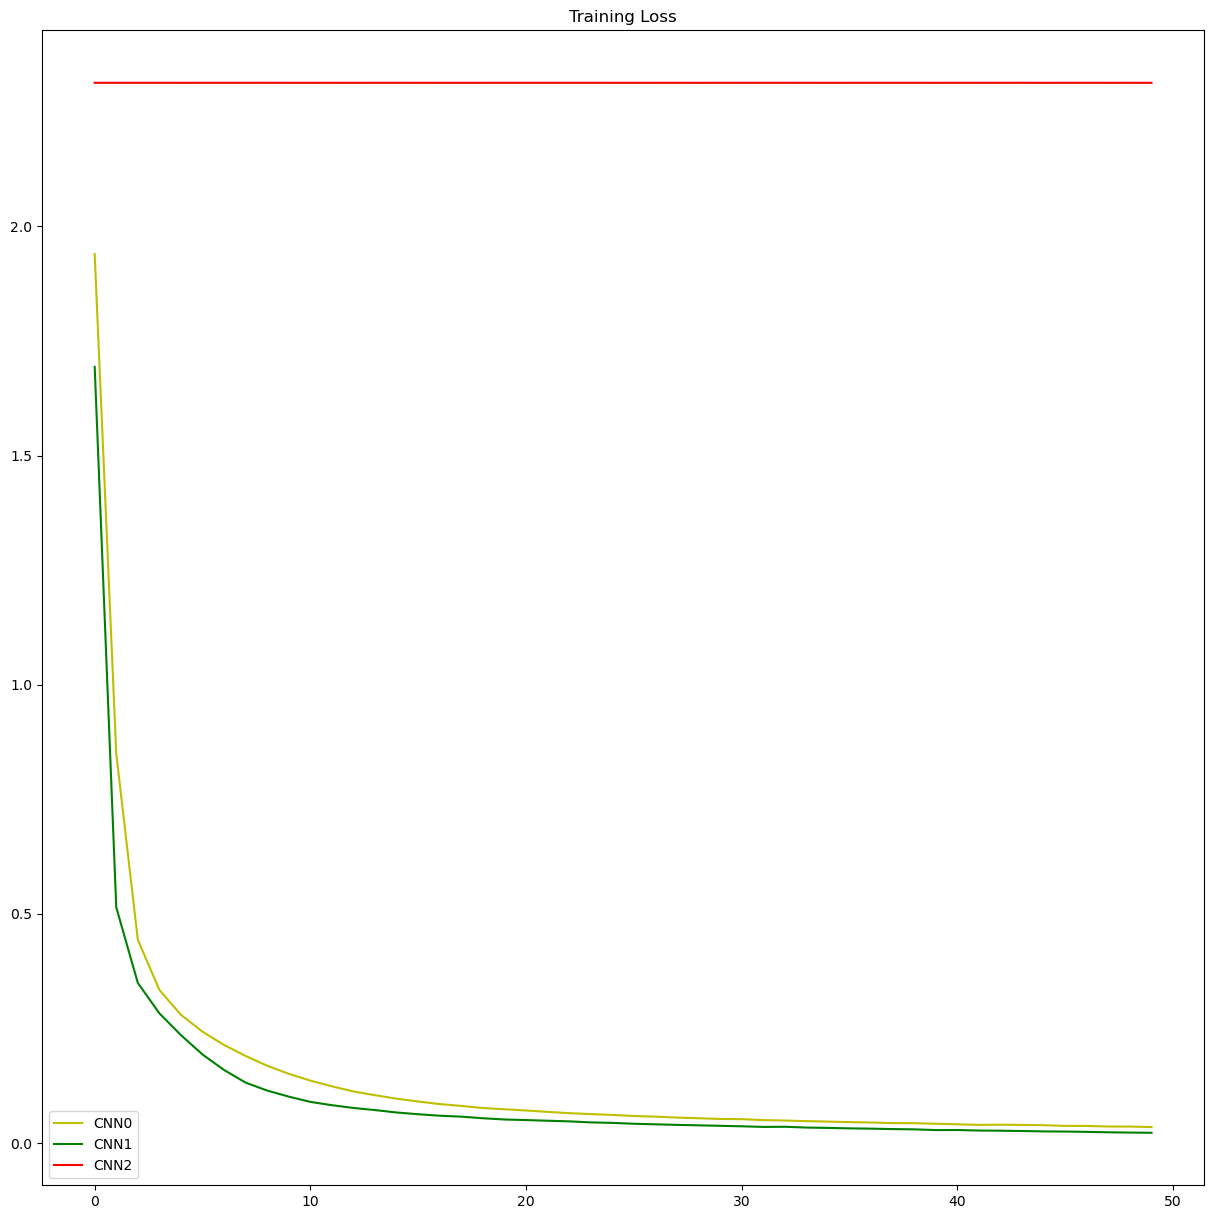

In [24]:
# plt.figure(figsize=(15, 15))
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(training_loss0, 'y-', label='CNN0')
ax1.plot(training_loss1, 'g-', label='CNN1')
ax1.plot(training_loss2, 'r-', label='CNN2')
ax1.legend()
ax1.set_title('Training Loss')

plt.show()
fig.savefig(os.path.join(path2write, 'loss.png'))




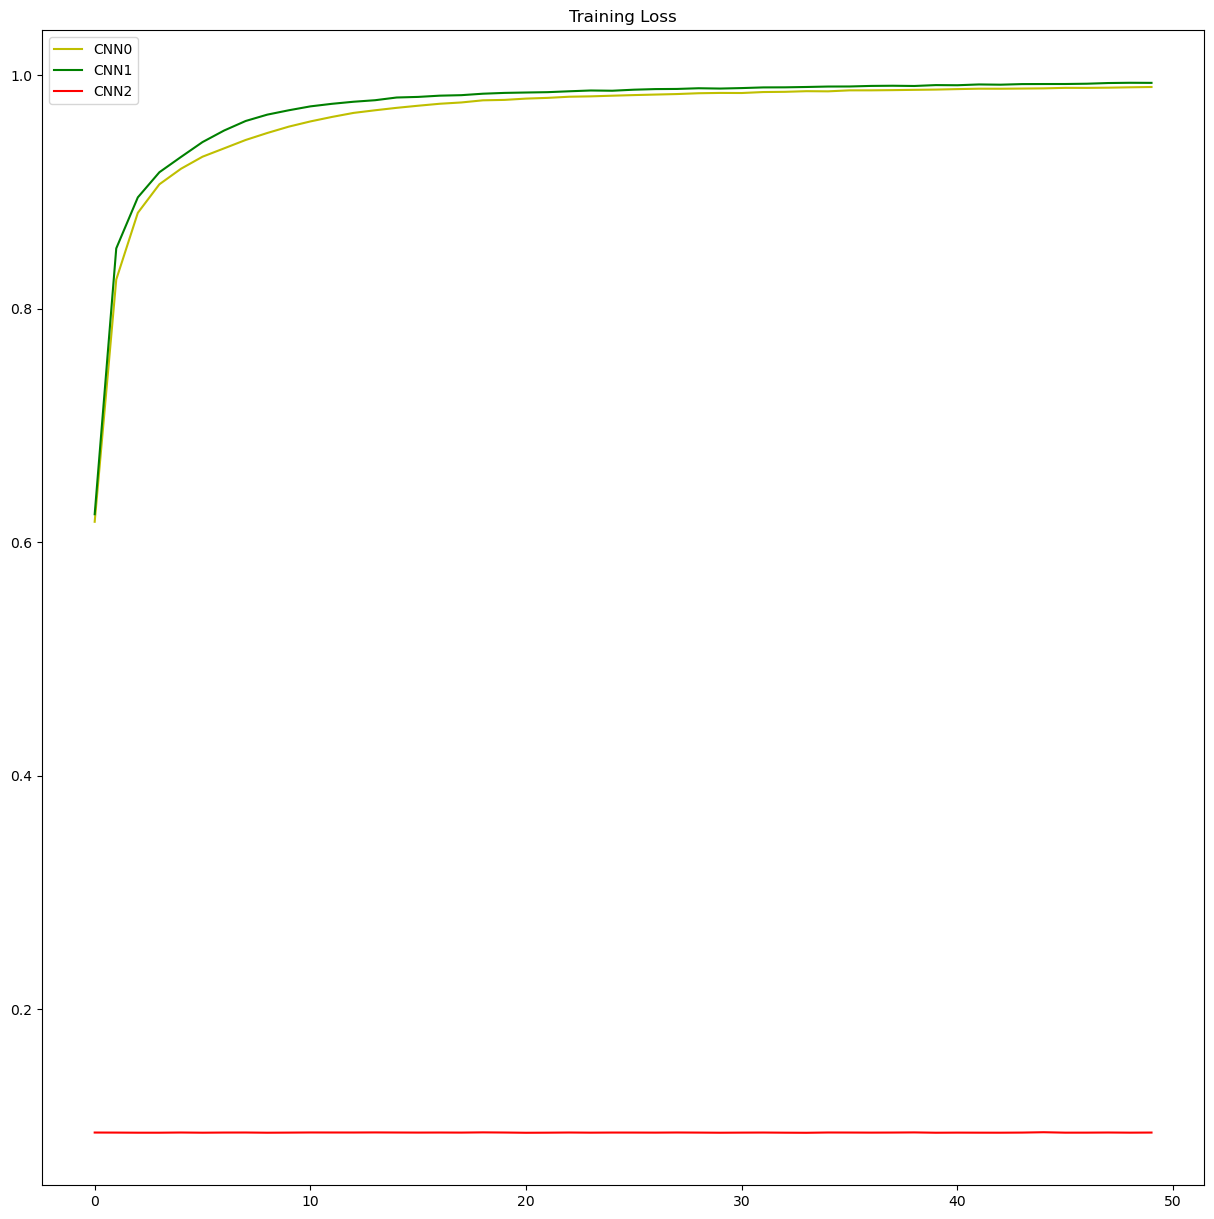

In [25]:
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(training_accuracy0, 'y-', label='CNN0')
ax1.plot(training_accuracy1, 'g-', label='CNN1')
ax1.plot(training_accuracy2, 'r-', label='CNN2')
ax1.legend()
ax1.set_title('Training Loss')

plt.show()
fig.savefig(os.path.join(path2write, 'Accuracy.png'))